<a href="https://www.kaggle.com/amindadgar/image-classification?scriptVersionId=85957373" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf 
from tensorflow import keras
import urllib.request
import matplotlib.pyplot as plt


In [2]:
def getImagesFromDirectory(train_data_gen, validation_data_gen, directory, image_size=(180,180), batch_size=12, shuffle=True):
    train_dataset = train_data_gen.flow_from_directory(directory,
                                                    target_size=image_size, 
                                                    batch_size=batch_size,
                                                    subset='training',
                                                    class_mode='categorical',
                                                    shuffle=True,
                                                    seed=123)
    validation_dataset = validation_data_gen.flow_from_directory(directory,
                                                          target_size=image_size,
                                                          batch_size=batch_size,
                                                          shuffle=True,
                                                          subset='validation',
                                                          class_mode='categorical',
                                                          seed=123)
    return train_dataset, validation_dataset

In [3]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1)
validate_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1)

## get the dataset from directory
train_dataset, validation_dataset = getImagesFromDirectory(
            train_data_gen=train_datagen,
            validation_data_gen=validate_datagen,
            directory='/kaggle/input/natural-images/natural_images')

Found 6213 images belonging to 8 classes.
Found 686 images belonging to 8 classes.



User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=false
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_PATTERN='hyper,hyper'
   KMP_REDUCTION_BARRIER='1,1'
  

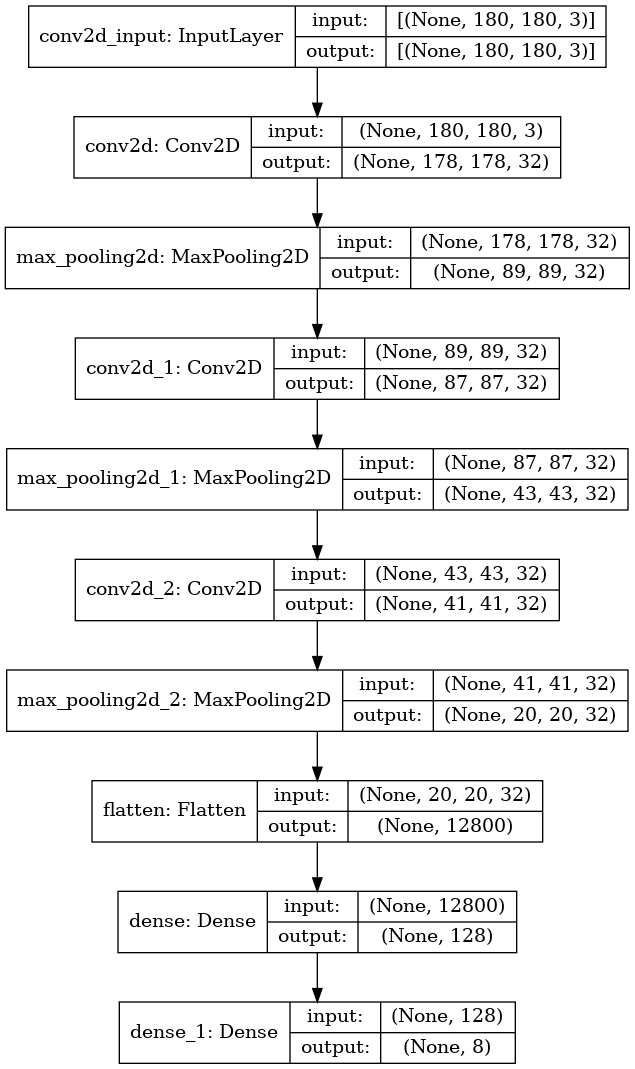

In [4]:
def create_model2(input_shape, pool_size=(2,2)):
    
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(32, (3, 3), input_shape = input_shape, activation = 'relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size = pool_size))
    
    model.add(tf.keras.layers.Conv2D(32, (3, 3), input_shape = input_shape, activation = 'relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size = pool_size))
    
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size = pool_size))
    ## reshape tensor shapes 
    model.add(tf.keras.layers.Flatten())
    ## Connect all perceptrons densly to 128 new perceptron in the new layer
    model.add(tf.keras.layers.Dense(units = 128, activation = 'relu'))
    num_classes = 8
    ## Connect all perceptrons densly to 20 new perceptron in the output layer
    model.add(tf.keras.layers.Dense(units = num_classes, activation = 'softmax'))
    
    return model    
model = create_model2(input_shape=(180,180) + (3,))
keras.utils.plot_model(model, show_shapes=True)

In [5]:
## Custom functions to check scores
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [6]:
## Run the model with number of epochs
epochs = 5

## save the model found in each iteration
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("model_save_at_{epoch}.h5"),
]
model.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=["categorical_accuracy",f1_m, precision_m, recall_m],
)
## Train the model and get the history
history = model.fit(
    train_dataset, epochs=epochs, callbacks=callbacks,
    validation_data=validation_dataset
)

2022-01-23 14:46:49.965893: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5
518/518 [==============================] - 96s 183ms/step - loss: 0.5642 - categorical_accuracy: 0.7943 - f1_m: 0.7755 - precision_m: 0.8479 - recall_m: 0.7282 - val_loss: 0.4130 - val_categorical_accuracy: 0.8528 - val_f1_m: 0.8455 - val_precision_m: 0.9083 - val_recall_m: 0.7974
Epoch 2/5
518/518 [==============================] - 81s 156ms/step - loss: 0.2218 - categorical_accuracy: 0.9179 - f1_m: 0.9175 - precision_m: 0.9356 - recall_m: 0.9015 - val_loss: 0.2752 - val_categorical_accuracy: 0.8936 - val_f1_m: 0.8965 - val_precision_m: 0.9145 - val_recall_m: 0.8807
Epoch 3/5
518/518 [==============================] - 81s 156ms/step - loss: 0.1387 - categorical_accuracy: 0.9469 - f1_m: 0.9470 - precision_m: 0.9543 - recall_m: 0.9405 - val_loss: 0.3206 - val_categorical_accuracy: 0.9009 - val_f1_m: 0.9035 - val_precision_m: 0.9111 - val_recall_m: 0.8966
Epoch 4/5
518/518 [==============================] - 82s 157ms/step - loss: 0.0919 - categorical_accuracy: 0.9681 - f1_m: 0.

In [7]:
link = "https://scontent-frt3-1.cdninstagram.com/v/t51.2885-15/e35/203937871_516266329513830_4919080390915015277_n.jpg?_nc_ht=scontent-frt3-1.cdninstagram.com&_nc_cat=106&_nc_ohc=RS-_f8P_TtUAX_YqnpP&edm=ALQROFkBAAAA&ccb=7-4&ig_cache_key=MjYwMDA1NDQzODM3NjAzNzI4NA%3D%3D.2-ccb7-4&oh=00_AT8tjFK75dFaQefVq7L_BnDW3ZFsSA4vBKcCAm4z_uloUg&oe=61F4D389&_nc_sid=30a2ef"

urllib.request.urlretrieve(link, '/kaggle/working/image.jpg' )


('/kaggle/working/image.jpg', <http.client.HTTPMessage at 0x7f6aebbb38d0>)

In [8]:
!ls

__notebook_source__.ipynb  model_save_at_1.h5  model_save_at_4.h5
image.jpg		   model_save_at_2.h5  model_save_at_5.h5
model.png		   model_save_at_3.h5


In [9]:
img = image.load_img('image.jpg', target_size=(180,180))
np.array(img).shape


(180, 180, 3)

In [10]:
img = tf.keras.preprocessing.image.img_to_array(img)
img = np.expand_dims(img, axis = 0)

model.predict(img)

array([[0., 0., 1., 0., 0., 0., 0., 0.]], dtype=float32)

In [16]:
!pwd

/kaggle/working


## To Load model 

In [18]:
## because we used some custom objects during training process, To load the model we need to mention them in load_model function
custom_objects={"recall_m": recall_m, "precision_m": precision_m, "f1_m": f1_m}

## we have loaded the model in epoch 3 because its accuracy is better than other epochs
## Note: epoch meaning the iteration over all images
model_ = keras.models.load_model('./model_save_at_3.h5', custom_objects)

In [19]:
## load the image we have downloaded

img = keras.preprocessing.image.load_img('image.jpg', target_size=(180,180))
np.array(img).shape


(180, 180, 3)

In [20]:
## apply some prepration to the image
img = tf.keras.preprocessing.image.img_to_array(img)
img = np.expand_dims(img, axis = 0)

## then we can predict
model_.predict(img)

array([[0., 0., 0., 0., 1., 0., 0., 0.]], dtype=float32)

As we can see the class for the image is 5. meaning class 5 in train folder is chosen. If we want to know which class it is, we can count the folders in dataset. By counting we saw that flower is chosen at classified class!